1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


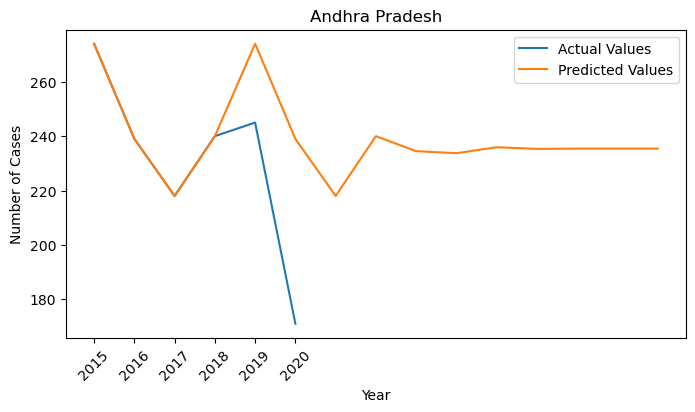

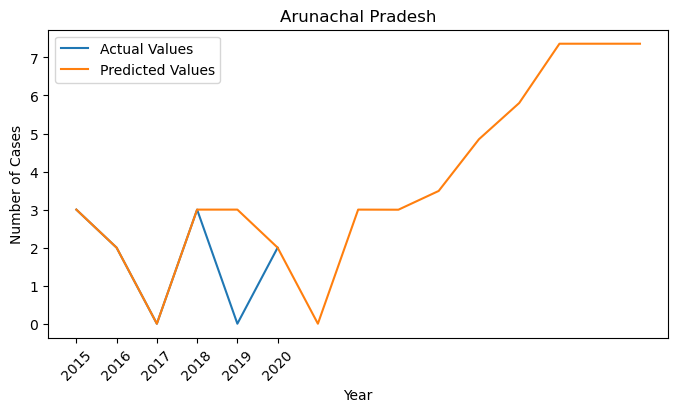

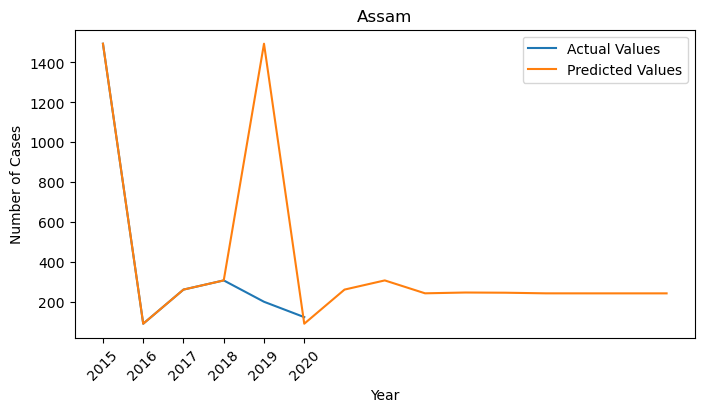

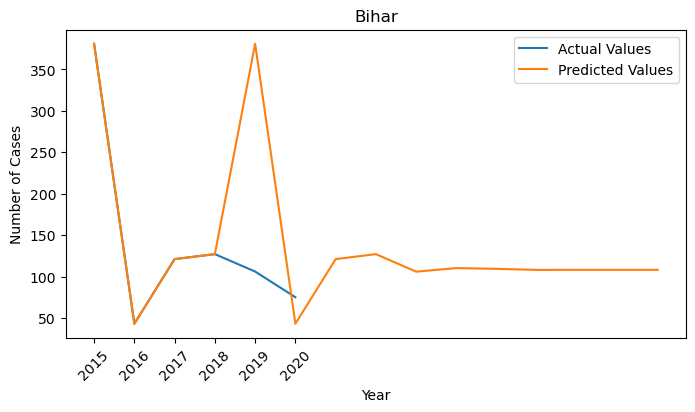

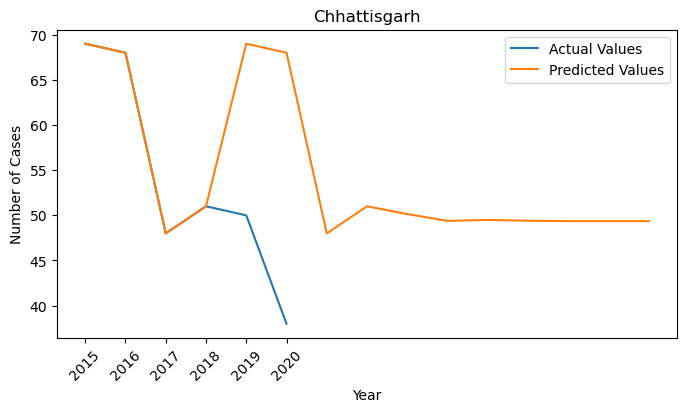

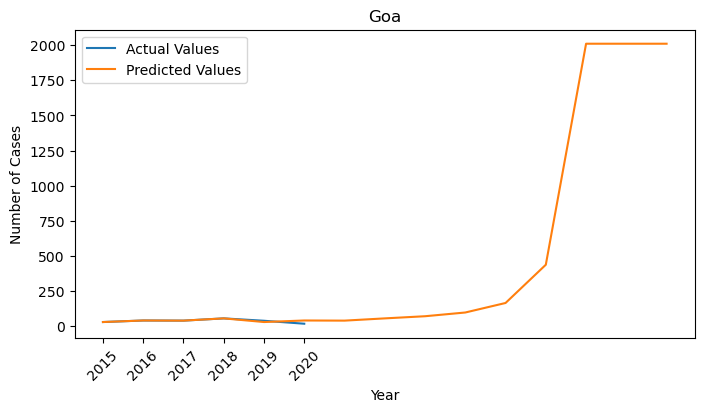

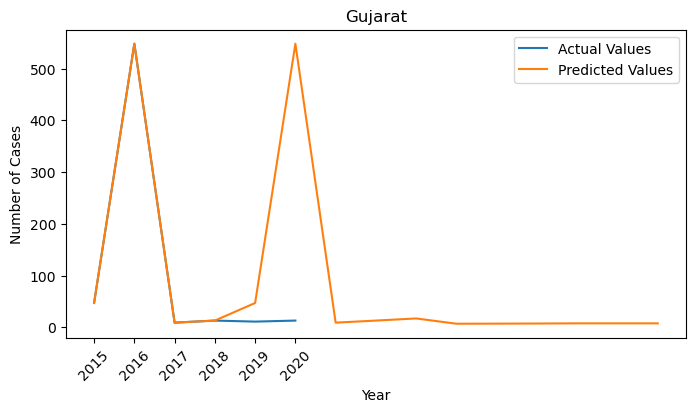

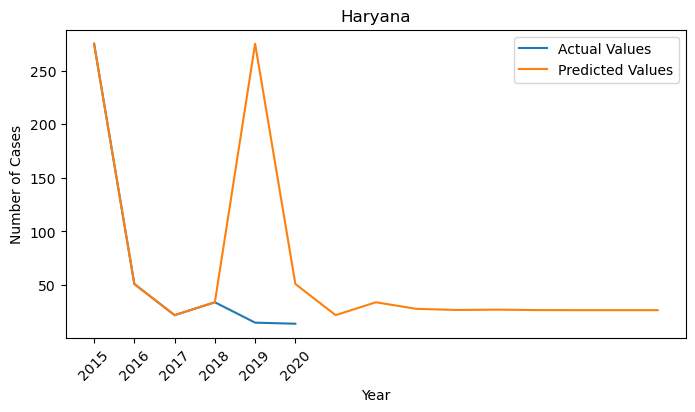

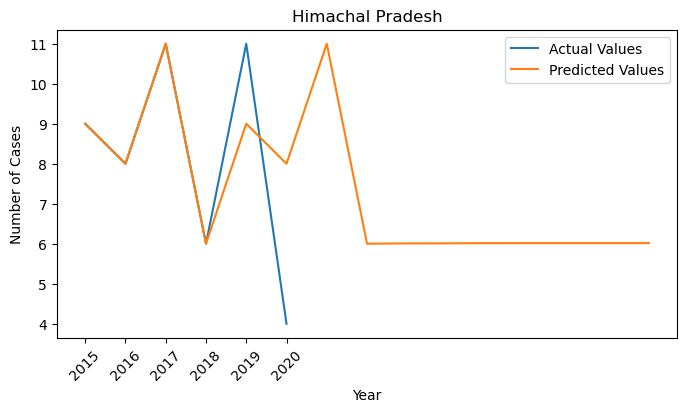

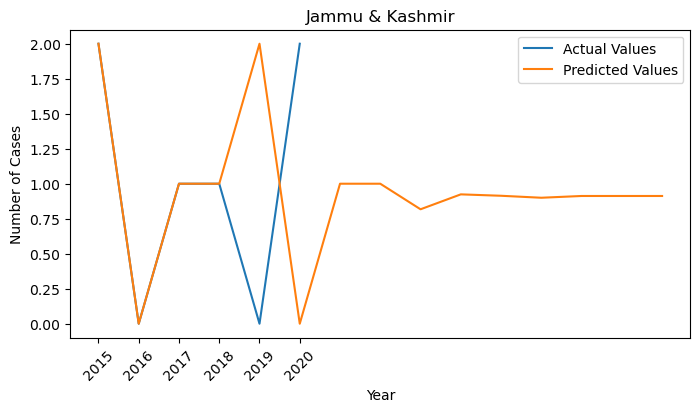

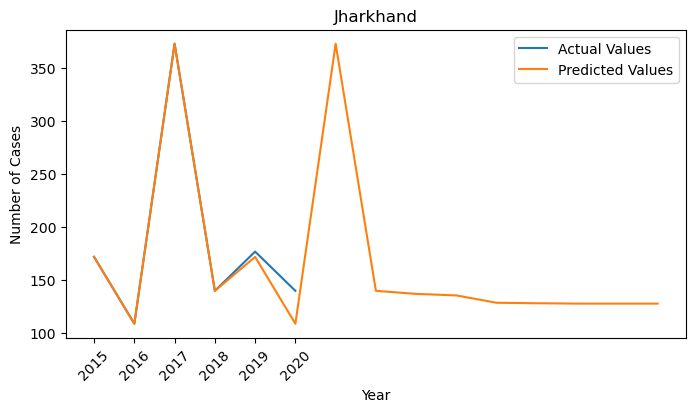

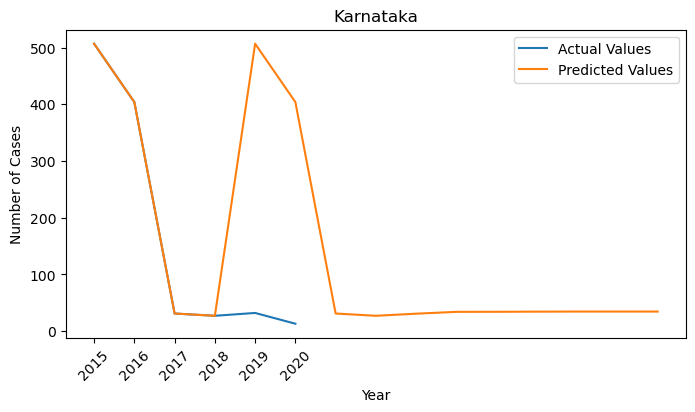

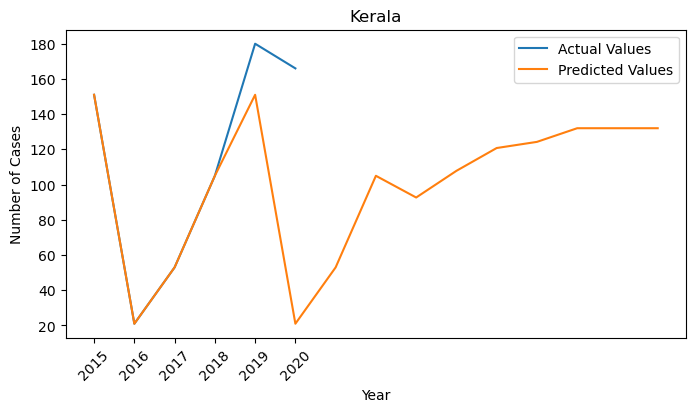

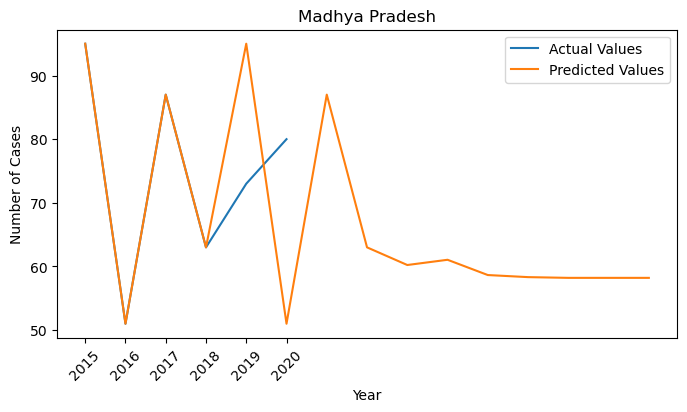

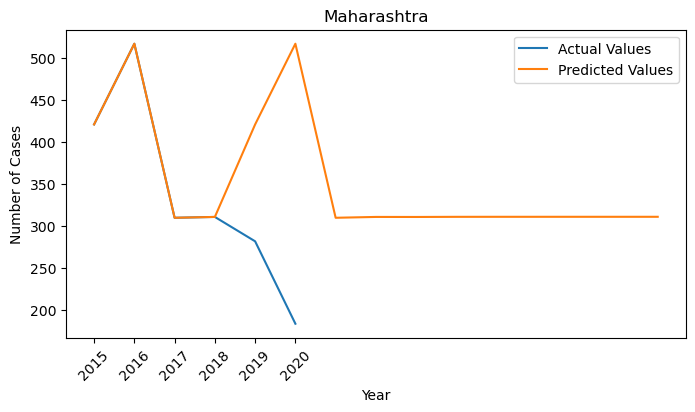

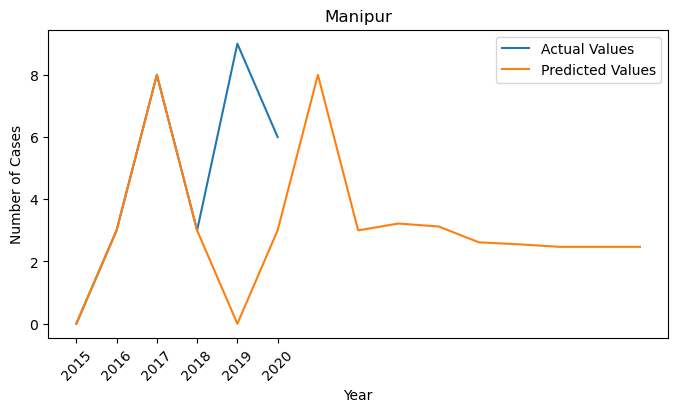

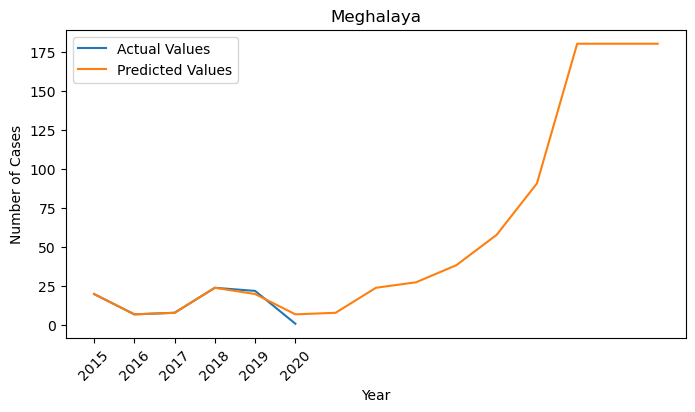

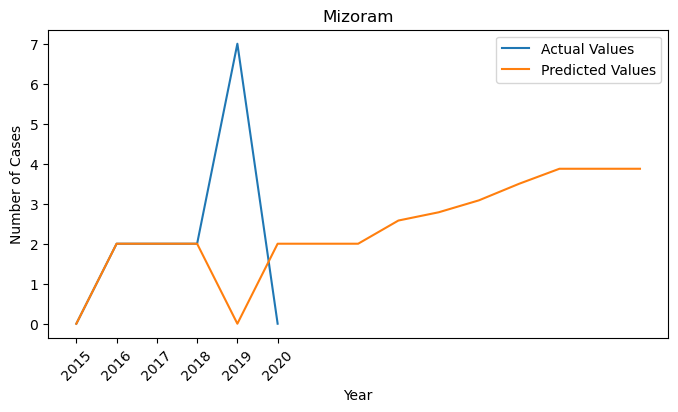

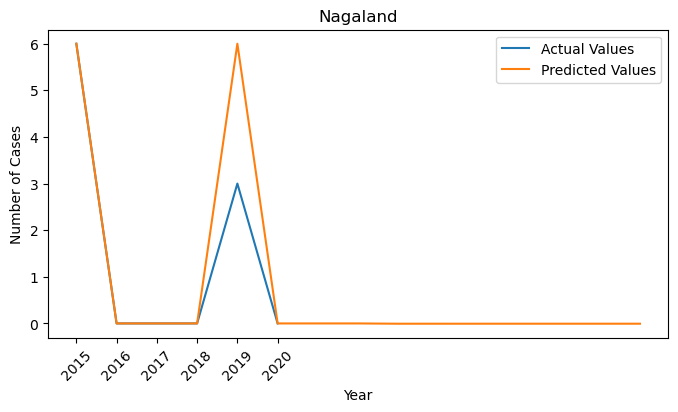

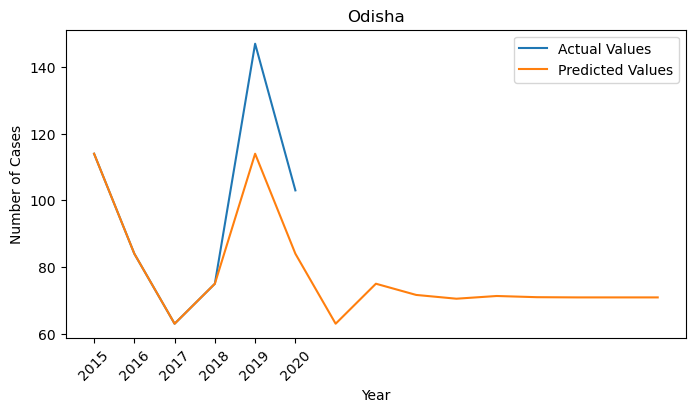

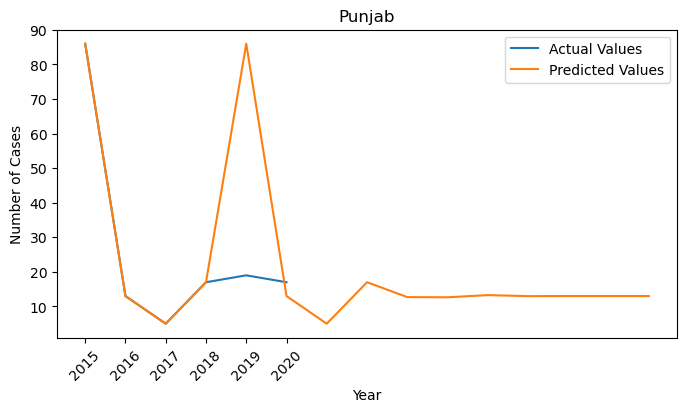

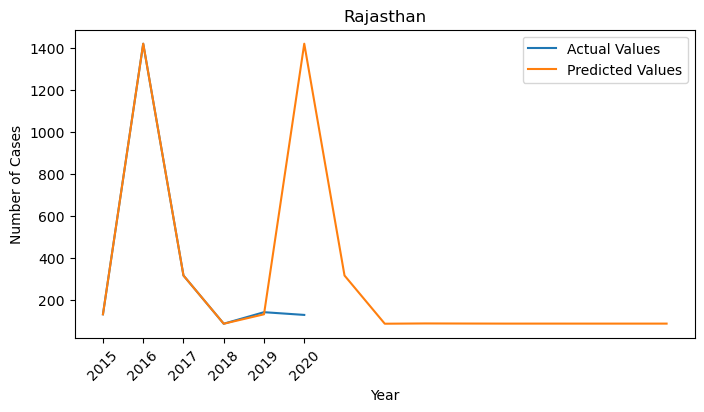

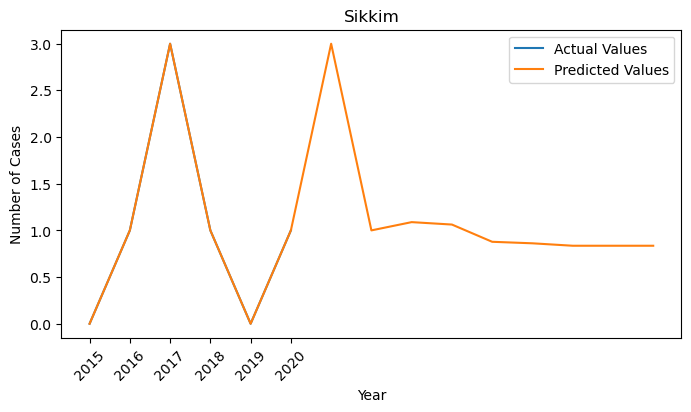

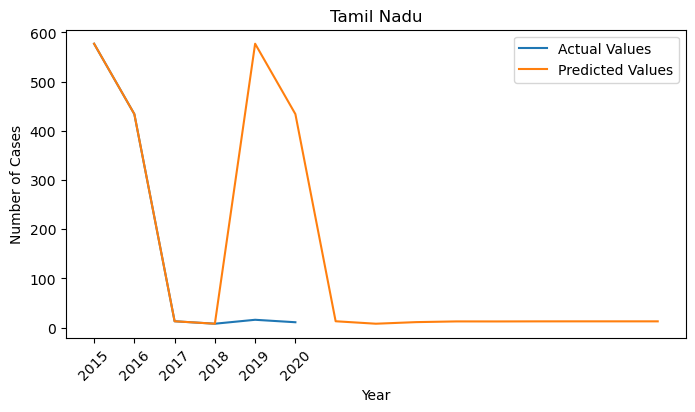

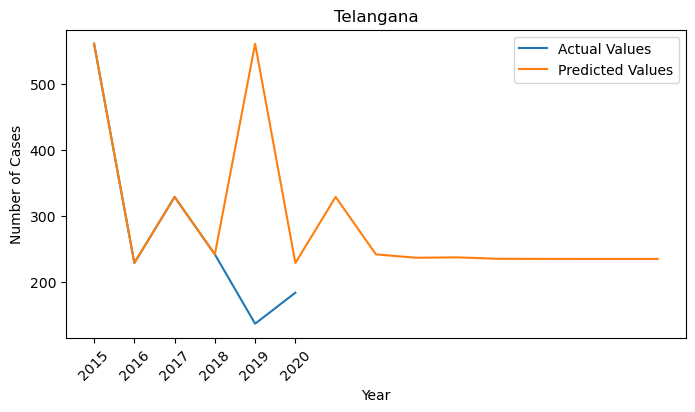

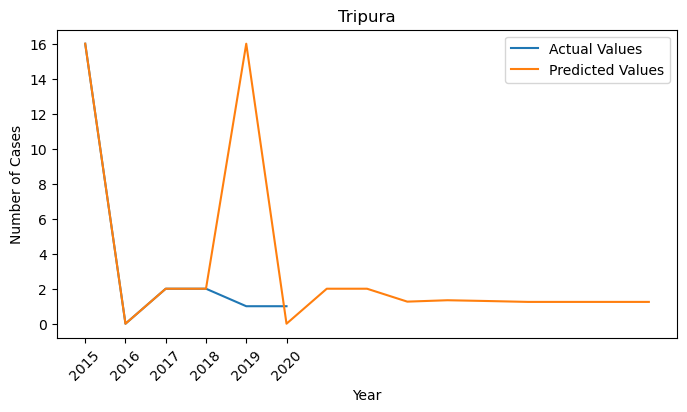

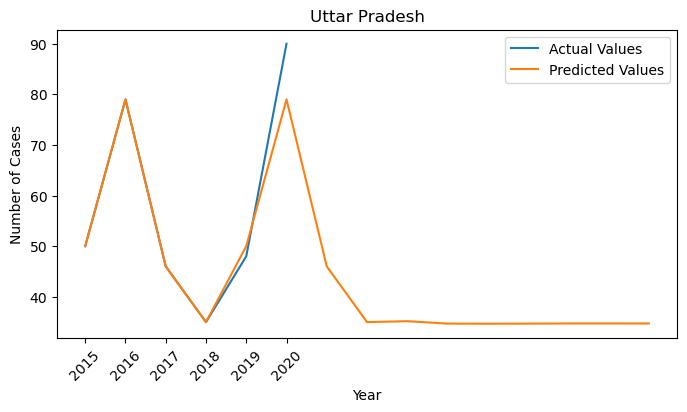

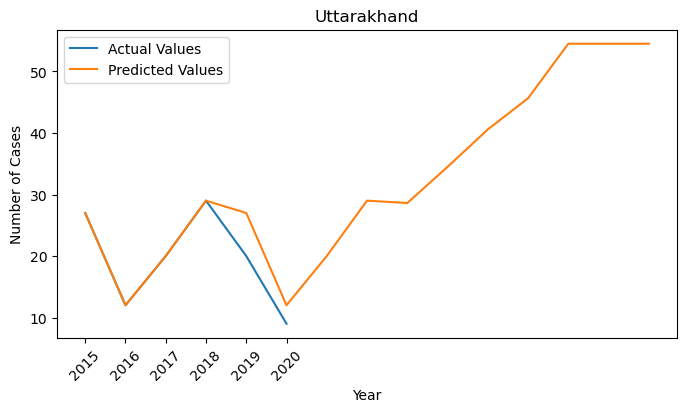

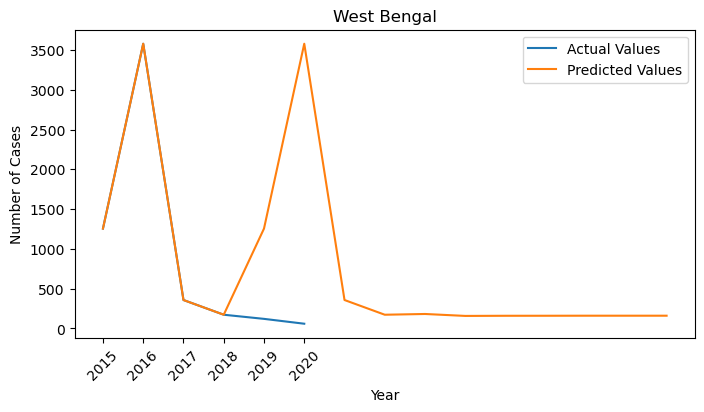

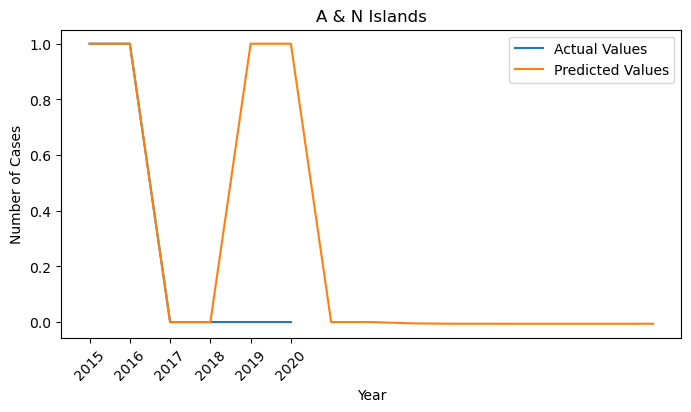

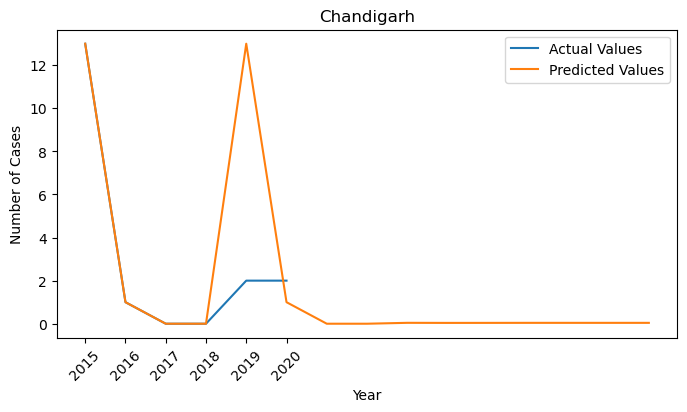

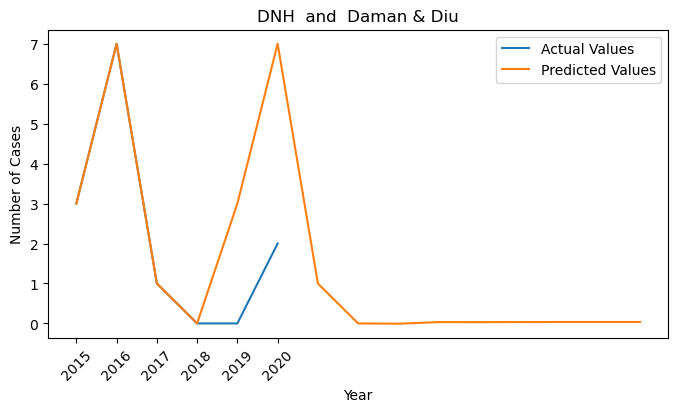

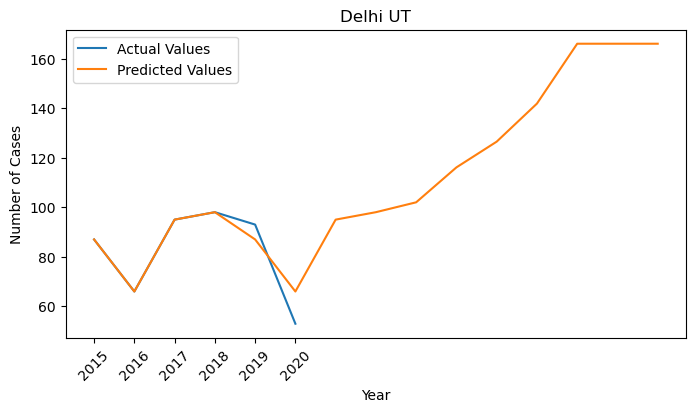

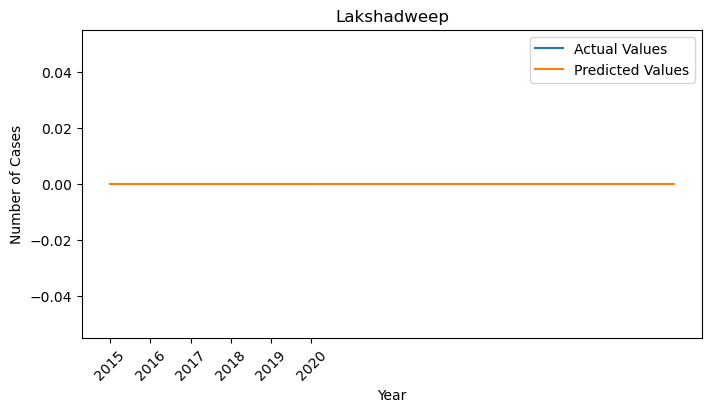

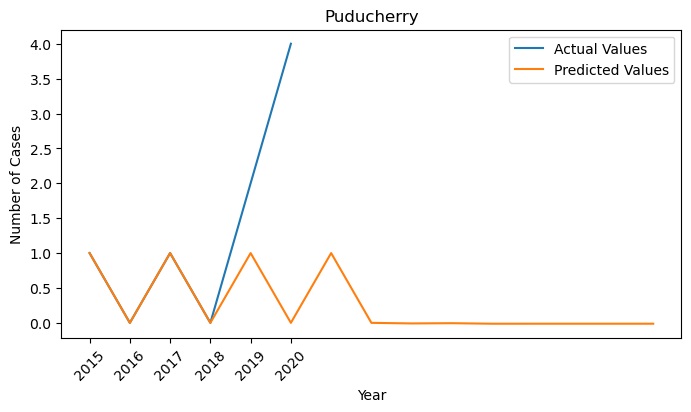

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Human trafficking 15-20.csv')

# Get the list of states from the first column
states = df.iloc[:, 0].unique()

# Create a dictionary to store the models and predictions for each state
models = {}
predictions = {}

# Loop over each state and train a separate LSTM model
for state in states:
    # Get the data for the current state
    data = df[df.iloc[:, 0] == state].iloc[:, 1:].squeeze().values

    # Split the data into training and testing sets
    train_data = data[:-2]
    test_data = data[-2:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data = scaler.fit_transform(train_data.reshape(-1, 1))
    test_data = scaler.transform(test_data.reshape(-1, 1))

    # Convert the data into sequences of length 3
    train_sequences = []
    train_labels = []
    for i in range(3, len(train_data)):
        train_sequences.append(train_data[i-3:i])
        train_labels.append(train_data[i])
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    # Build the LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(3, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(train_sequences, train_labels, epochs=100, verbose=0)

    # Make predictions for the next 5 years
    test_sequences = []
    last_sequence = train_data[-3:]
    for i in range(5):
        next_sequence = model.predict(last_sequence.reshape(1, 3, 1))
        test_sequences.append(next_sequence)
        last_sequence = np.vstack([last_sequence[1:], next_sequence])
    test_sequences = np.array(test_sequences)
    test_sequences = scaler.inverse_transform(test_sequences.reshape(-1, 1)).squeeze()
    predictions[state] = np.concatenate([data[:-2], test_sequences])

    # Store the trained model
    models[state] = model

# Plot the predicted values for each state
for state in states:
    # Get the actual and predicted values for the current state
    actual_values = df[df.iloc[:, 0] == state].iloc[:, 1:].squeeze().values
    predicted_values = np.concatenate([actual_values[:-2], predictions[state], np.repeat(predictions[state][-1], 2)])

    # Create a plot for the current state
    plt.figure(figsize=(8, 4))
    plt.plot(actual_values, label='Actual Values')
    plt.plot(predicted_values, label='Predicted Values')
    plt.xticks(np.arange(len(actual_values)), np.arange(2015, 2023), rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Number of Cases')
    plt.title(state)
    plt.legend()
    plt.show()

In [3]:
mse_values = {}
for state in states:
    actual_values = df[df.iloc[:, 0] == state].iloc[:, 1:].squeeze().values
    predicted_values = np.concatenate([actual_values[:-2], predictions[state], np.repeat(predictions[state][-1], 2)])
    mse = np.mean((actual_values - predicted_values)**2)
    mse_values[state] = mse

ValueError: operands could not be broadcast together with shapes (6,) (10,) 

In [ ]:
# Print MSE for each state
for state in states:
    print(f"MSE for {state}: {mse_values[state]:.2f}")
